In [1]:
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset, Dataset,random_split
from tqdm import tqdm

In [2]:
class MultiStepTimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length, n_steps):
        self.data = data
        self.seq_length = seq_length
        self.n_steps = n_steps

    def __len__(self):
        return len(self.data) - self.seq_length - self.n_steps + 1

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_length]
        y = self.data[idx+self.seq_length:idx+self.seq_length+self.n_steps]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

n_steps = 1
seq_length = 32
data = pd.read_csv("ecg_x.csv", index_col=0).values
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

dataset = MultiStepTimeSeriesDataset(data, seq_length, n_steps)

# 划分数据集
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [3]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

class IndependentTransformerModel(nn.Module):
    def __init__(self, input_dim, model_dim, n_heads, num_encoder_layers, num_decoder_layers, n_steps):
        super(IndependentTransformerModel, self).__init__()
        self.model_dim = model_dim
        self.input_dim = input_dim
        self.n_steps = n_steps
        self.embeddings = nn.ModuleList([nn.Linear(1, model_dim) for _ in range(input_dim)])
        self.transformers = nn.ModuleList([nn.Transformer(d_model=model_dim, nhead=n_heads, 
                                                          num_encoder_layers=num_encoder_layers, 
                                                          num_decoder_layers=num_decoder_layers) for _ in range(input_dim)])
        self.fcs = nn.ModuleList([nn.Linear(model_dim, 1) for _ in range(input_dim)])
    
    def forward(self, src):
        outputs = []
        for i in range(self.input_dim):
            src_channel = src[:, :, i].unsqueeze(-1)  
            src_embedded = self.embeddings[i](src_channel)
            src_embedded = src_embedded.permute(1, 0, 2)  
            output = self.transformers[i](src_embedded, src_embedded)
            output = self.fcs[i](output)
            output = output.permute(1, 0, 2)  
            outputs.append(output[:, -self.n_steps:, :]) 
        return torch.cat(outputs, dim=-1) 
    
    def extract_hidden_states(self, src):
        hidden_states = []
        for i in range(self.input_dim):
            src_channel = src[:, :, i].unsqueeze(-1)
            src_embedded = self.embeddings[i](src_channel)
            src_embedded = src_embedded.permute(1, 0, 2)
            output = self.transformers[i].encoder(src_embedded)
            hidden_states.append(output.permute(1, 0, 2)[:, -self.n_steps:, :])
        return torch.cat(hidden_states, dim=0) 


input_dim = data.shape[1]
model_dim = 32
n_heads = 8
num_encoder_layers = 2
num_decoder_layers = 2

model = IndependentTransformerModel(input_dim, model_dim, n_heads, num_encoder_layers, num_decoder_layers, n_steps).to(0)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)




/home/cpz/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
import torch
from tqdm import tqdm

num_epochs = 1000
best_loss = 1e9
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_total_loss = []
val_total_loss = []
for epoch in range(num_epochs):
    model.train()
    train_loss = [0] * 4
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        x, y = batch
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = huber_loss(output, y)
        loss.backward()
        optimizer.step()
        for i in range(4):
            train_loss[i] += huber_loss(output[:, :, i], y[:, :, i]).item()

    val_loss = [0] * 4
    model.eval()
    with torch.no_grad():
        for batch in val_dataloader:
            x, y = batch
            x, y = x.to(device), y.to(device)
            output = model(x)
            for i in range(4):
                val_loss[i] += huber_loss(output[:, :, i], y[:, :, i]).item()

    avg_train_loss = [loss / len(train_dataloader) for loss in train_loss]
    avg_val_loss = [loss / len(val_dataloader) for loss in val_loss]

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}')
    train_total_loss.append(avg_train_loss)
    val_total_loss.append(avg_val_loss)
    total_val_loss = sum(avg_val_loss)
    if total_val_loss < best_loss:
        best_loss = total_val_loss
        torch.save(model.state_dict(), 'model_12_2.pth')

test_loss = [0] * 4
model.eval()
with torch.no_grad():
    for batch in test_dataloader:
        x, y = batch
        x, y = x.to(device), y.to(device)
        output = model(x)
        for i in range(4):
            test_loss[i] += huber_loss(output[:, :, i], y[:, :, i]).item()

avg_test_loss = [loss / len(test_dataloader) for loss in test_loss]
print(f'Test Loss: {avg_test_loss}')

In [4]:
model.load_state_dict(torch.load('model_32.pth'))

<All keys matched successfully>

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def prediction(start_index, seq_length, n_steps, prediction_horizon, data):
    model.to(device)
    model.eval()
    all_predictions = []
    mse_loss = []
    criterion = nn.MSELoss()
    hidden_states = []
    with torch.no_grad():
        for i in tqdm(range(prediction_horizon)):
            input_sequence = data[start_index + i * n_steps : start_index + seq_length + i * n_steps]
            label = data[start_index+seq_length+i*n_steps].reshape(4)
            input_sequence_tensor = torch.tensor(input_sequence, dtype=torch.float32).unsqueeze(0).to(device) 
            
            predicted_sequence = model(input_sequence_tensor)
            label = torch.tensor(label, dtype=torch.float32)
            tamp = []
            for i in range(4):
                loss = criterion(predicted_sequence[0, :, i], label[i].to(0))
                tamp.append(loss.detach().cpu().numpy())
            mse_loss.append(np.array(tamp))
            all_predictions.append(predicted_sequence[0, :, :].cpu().numpy())  
            v = model.extract_hidden_states(input_sequence_tensor)
            hidden_states.append(v)
        
    all_predictions = np.array(all_predictions)
    full_sequence = data[start_index:start_index + seq_length + prediction_horizon * n_steps]
    all_predictions = np.array(all_predictions).reshape(-1, 4)
   
    mse_loss = np.array(mse_loss)
    return all_predictions, full_sequence, mse_loss, hidden_states

data = pd.read_csv("normal_xingeng.csv", index_col=0).values
prediction_res, full_sequence, loss, hidden_states = prediction(0, 32, 1, 2100, data)

  0%|          | 0/2100 [00:00<?, ?it/s]

/home/cpz/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 2100/2100 [00:28<00:00, 73.21it/s]


In [6]:
test_loss = 0
model.eval()
mse = nn.MSELoss()
xingeng = pd.read_csv("xingeng_test.csv", index_col=0).values
xingeng = scaler.fit_transform(xingeng)
xingeng = MultiStepTimeSeriesDataset(xingeng, seq_length, n_steps)
y_true_normal = np.zeros(len(test_dataset))
y_pred_normal = np.zeros(len(test_dataset))
loss_val = []
hidden_states_normal = []
with torch.no_grad():
    for i, (x, y) in enumerate(val_dataset):
        x, y = x.to(device), y.to(device)
        out = model(x.reshape(-1, 32, 4))
        hidden_states_normal.append(model.extract_hidden_states(x.reshape(-1, 32, 4)))
        tamp = []
        for i in range(4):
            loss_item = mse(y.reshape(4)[i], out.reshape(4)[i])
            tamp.append(loss_item.cpu())
        loss_val.append(np.array(tamp))

In [7]:
len(hidden_states)
hidden_states_t = []
for i in range(len(hidden_states)):
    hidden_states_t.append(hidden_states[i].cpu())
ch1 = []
ch2 = []
ch3 = []
ch4 = []
for i in range(len(hidden_states_t)):
    ch1.append(hidden_states_t[i][0, 0, :].detach().cpu().numpy())
    ch2.append(hidden_states_t[i][1, 0, :].detach().cpu().numpy())
    ch3.append(hidden_states_t[i][2, 0, :].detach().cpu().numpy())
    ch4.append(hidden_states_t[i][3, 0, :].detach().cpu().numpy())
ch1 = np.array(ch1)
ch2 = np.array(ch2)
ch3 = np.array(ch3)
ch4 = np.array(ch4)
from sklearn.decomposition import PCA

import umap
# pca = PCA(n_components=2)
umap_reducer = umap.UMAP(n_components=2)
hidden_states_umap_1 = umap_reducer.fit_transform(ch1)
hidden_states_umap_2 = umap_reducer.fit_transform(ch2)
hidden_states_umap_3 = umap_reducer.fit_transform(ch3)
hidden_states_umap_4 = umap_reducer.fit_transform(ch4)

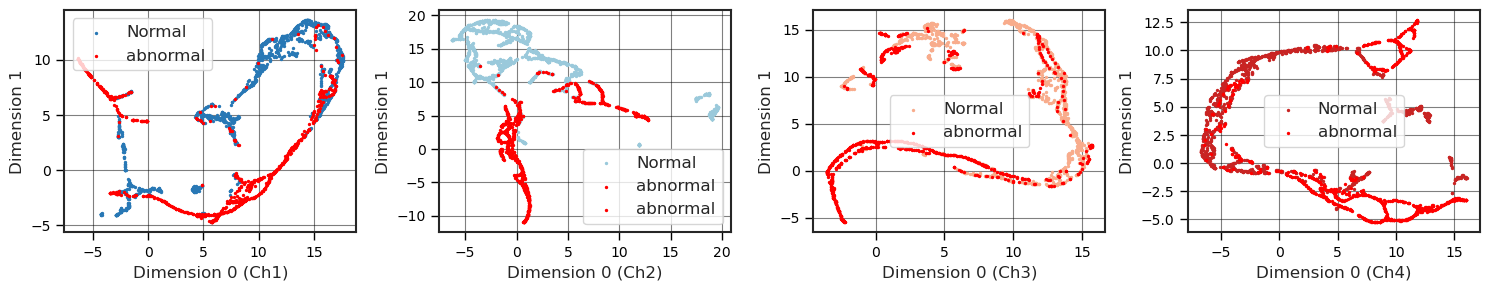

In [16]:
color = ['#2878B5', '#9AC9DB', '#F8AC8C', '#C82423']
import seaborn as sns
sns.set_style('white')
fig, ax = plt.subplots(1, 4, figsize=(15, 3))
ax[0].scatter(hidden_states_umap_1[:1300, 0], hidden_states_umap_1[:1300, 1], c=color[0], s=2, label='Normal')
ax[0].scatter(hidden_states_umap_1[1300:2300, 0], hidden_states_umap_1[1300:2300, 1], c='r', s=2, label='abnormal')
ax[0].set_xlabel("Dimension 0 (Ch1)",fontsize=12)
ax[0].set_ylabel("Dimension 1",fontsize=12)
ax[0].legend(fontsize=12)
ax[0].grid(True)

ax[1].scatter(hidden_states_umap_2[:1300, 0], hidden_states_umap_2[:1300, 1], c=color[1], s=2,label='Normal')
ax[1].scatter(hidden_states_umap_2[2300:, 0], hidden_states_umap_2[2300:, 1], c='r', s=2, label='abnormal')
ax[1].scatter(hidden_states_umap_2[1300:, 0], hidden_states_umap_2[1300:, 1], c='r', s=2, label='abnormal')
ax[1].set_xlabel("Dimension 0 (Ch2)",fontsize=12)
ax[1].set_ylabel("Dimension 1",fontsize=12)
ax[1].legend(fontsize=12)
ax[1].grid(True)

ax[2].scatter(hidden_states_umap_3[:1300, 0], hidden_states_umap_3[:1300, 1], c=color[2], s=2,label='Normal')
# ax[2].scatter(hidden_states_umap_3[:100, 0], hidden_states_umap_3[:1300, 1], c=color[2], s=2)
ax[2].scatter(hidden_states_umap_3[1300:, 0], hidden_states_umap_3[1300:, 1], c='r', s=2, label='abnormal')
ax[2].set_xlabel("Dimension 0 (Ch3)",fontsize=12)
ax[2].set_ylabel("Dimension 1",fontsize=12)
ax[2].legend(fontsize=12)
ax[2].grid(True)
ax[3].scatter(hidden_states_umap_4[:1300, 0], hidden_states_umap_4[:1300, 1], c=color[3], s=2,label='Normal')
ax[3].scatter(hidden_states_umap_4[1300:, 0], hidden_states_umap_4[1300:, 1], c='r', s=2, label='abnormal')
ax[3].set_xlabel("Dimension 0 (Ch4)",fontsize=12)
ax[3].set_ylabel("Dimension 1", fontsize=12)
ax[3].legend(fontsize=12)
ax[3].grid(True)
for axis in ax:
    for spine in axis.spines.values():
        spine.set_linewidth(1.5)
    axis.tick_params(axis='both', which='both', direction='out', length=6, width=1, colors='k', grid_color='k', grid_alpha=0.5)
    axis.xaxis.set_ticks_position(position='bottom')
    axis.yaxis.set_ticks_position(position='left')
plt.tight_layout()
plt.savefig("vis.png", dpi=300)



In [17]:
loss_val = np.array(loss_val)
thresholds = []
for i in range(4):
    mean = np.mean(loss_val[:, 0])
    std = np.std(loss_val[:, 0])
    thresholds.append(mean+std)

In [18]:
y_true_normal_3 = np.zeros(len(test_dataset))
y_pred_normal_3 = np.zeros(len(test_dataset))
for i in range(len(loss_val[:, 2])):
    if loss_val[i, 2] > 0.01:
        y_pred_normal_3[i]=1

y_true_normal_2 = np.zeros(len(test_dataset))
y_pred_normal_2 = np.zeros(len(test_dataset))
for i in range(len(loss_val[:, 1])):
    if loss_val[i, 1] > thresholds[1]:
        y_pred_normal_2[i]=1
        
y_true_normal_1 = np.zeros(len(test_dataset))
y_pred_normal_1 = np.zeros(len(test_dataset))
for i in range(len(loss_val[:, 0])):
    if loss_val[i, 0] > thresholds[0]:
        y_pred_normal_1[i]=1

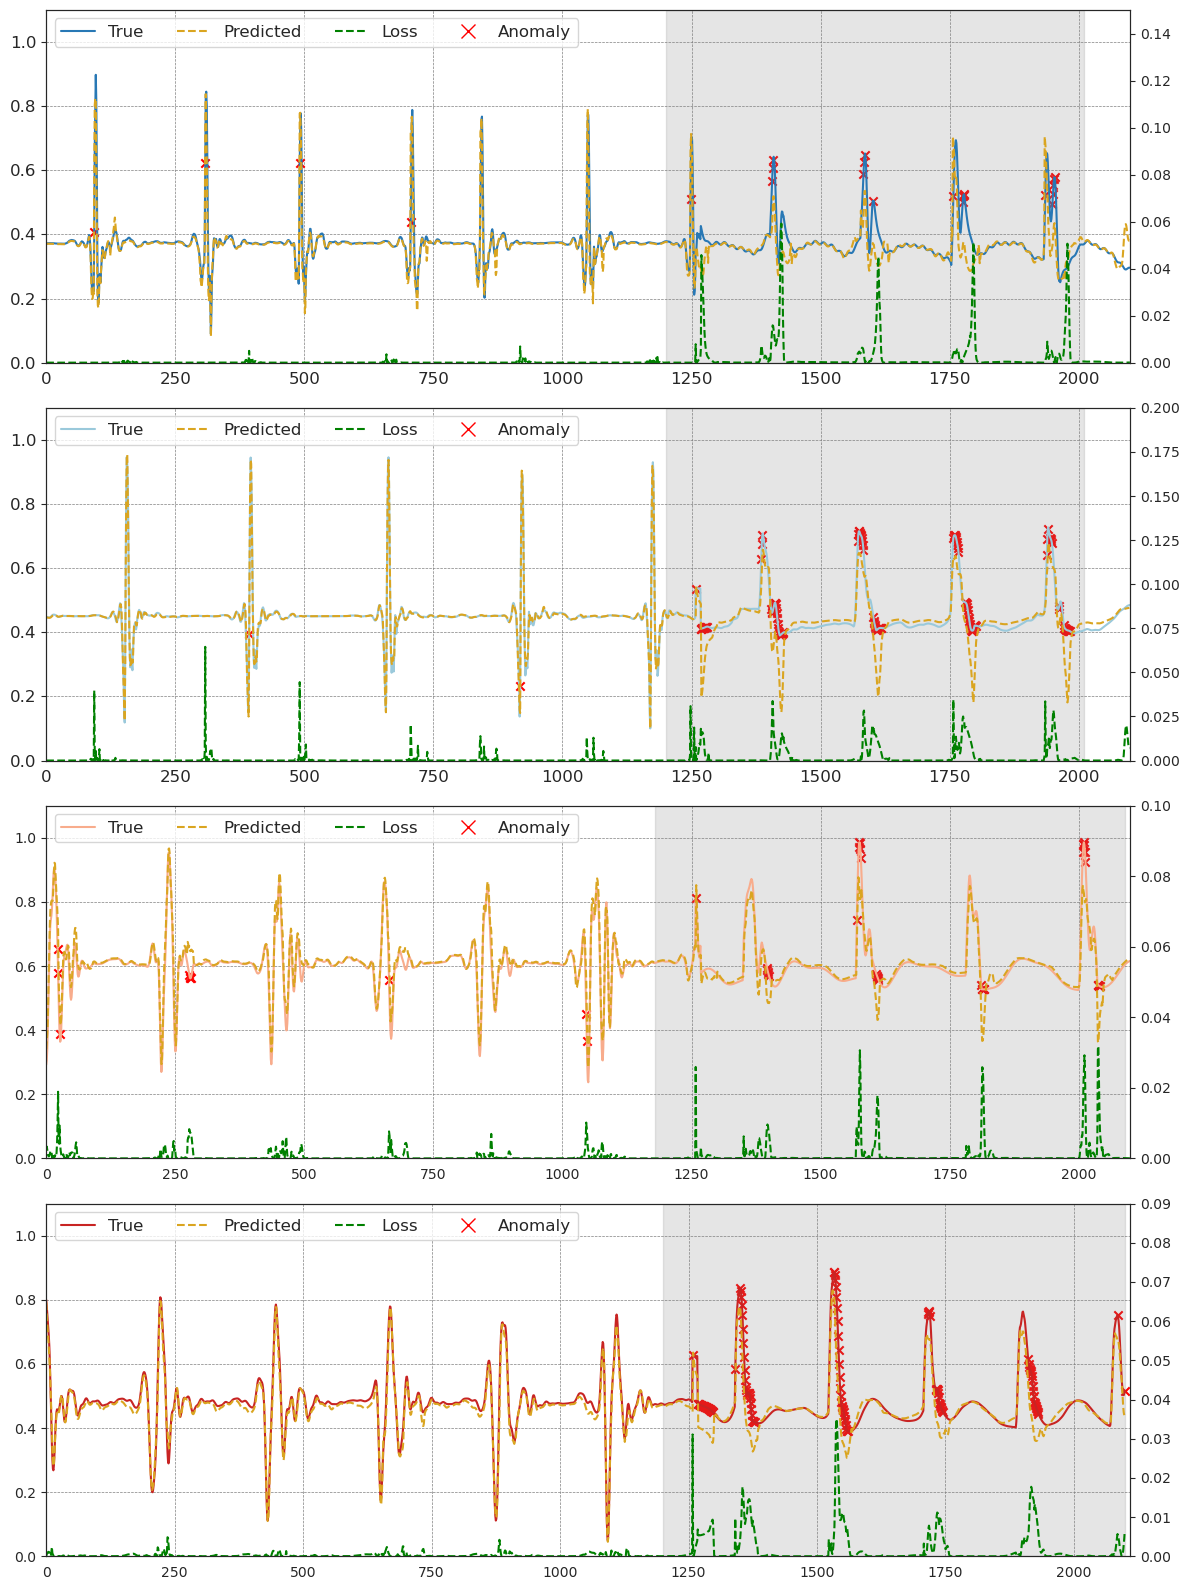

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

c = 0
t =32
m = 2100
fig, ax = plt.subplots(4, 1, figsize=(12, 16))
color = ['#2878B5', '#9AC9DB', '#F8AC8C', '#C82423']

# 绘制第一个子图
line1, = ax[0].plot(full_sequence[t:t+m, c], label='True', c=color[c])
line2, = ax[0].plot(prediction_res[1:m, c], label='Predicted', linestyle='--', c='#DAA520')

anomalies = np.where(loss[:m, c] > 0.02)[0]  # get indices of anomalies

ax[0].scatter(anomalies, full_sequence[t+anomalies, c], c='red', marker='x', label='Anomaly')
ax[0].set_xlim(0, m)
ax[0].set_ylim(0, 1.1)
ax[0].tick_params(axis='both', which='major', labelsize=12)
ax2 = ax[1].twinx()
line3, = ax2.plot(loss[:m, c], label='Loss', linestyle='--', c='g')
ax2.set_ylim(0, 0.2)
ax[0].axvspan(1200, 2010, color='grey', alpha=0.2, label='MI Area')
ax[0].grid(True, which='both', linestyle='--', linewidth=0.5, color='grey')
lines = [line1, line2, line3]
lines += [Line2D([0], [0], color='red', marker='x', linestyle='', markersize=10, label='Anomaly')]
labels = [l.get_label() for l in lines]
ax[0].legend(lines, labels, loc='upper left', ncol=4, fontsize=12)

# 绘制第二个子图
c = 1
line1, = ax[1].plot(full_sequence[t:t+m, c], label='True', c=color[c])
line2, = ax[1].plot(prediction_res[:m-1, c], label='Predicted', linestyle='--', c='#DAA520')
anomalies = np.where(loss[:m, c] > thresholds[c])[0]  # get indices of anomalies

ax[1].scatter(anomalies, full_sequence[t+anomalies, c], c='red', marker='x', label='Anomaly')
ax[1].set_xlim(0, m)
ax[1].set_ylim(0, 1.1)
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax2 = ax[0].twinx()
line3, = ax2.plot(loss[:m, c], label='Loss', linestyle='--', c='g')
ax2.set_ylim(0, 0.15)
ax[1].axvspan(1200, 2010, color='grey', alpha=0.2, label='MI Area')
ax[1].grid(True, which='both', linestyle='--', linewidth=0.5, color='grey')
lines = [line1, line2, line3]
lines += [Line2D([0], [0], color='red', marker='x', linestyle='', markersize=10, label='Anomaly')]
labels = [l.get_label() for l in lines]
ax[1].legend(lines, labels, loc='upper left', ncol=4, fontsize =12)

c = 2
line1, = ax[2].plot(full_sequence[t:t+m, c], label='True', c=color[c])
line2, = ax[2].plot(prediction_res[0:m-1, c], label='Predicted', linestyle='--', c='#DAA520')
anomalies = np.where(loss[:m, c] > 0.007)[0]  # get indices of anomalies

ax[2].scatter(anomalies, full_sequence[t+anomalies, c], c='red', marker='x', label='Anomaly')
ax[2].set_xlim(0, m)
ax[2].set_ylim(0, 1.1)
ax2 = ax[2].twinx()
line3, = ax2.plot(loss[:m, c], label='Loss', linestyle='--', c='g')
ax2.set_ylim(0, 0.1)
ax[2].axvspan(1180, 2090, color='grey', alpha=0.2, label='MI Area')
ax[2].grid(True, which='both', linestyle='--', linewidth=0.5, color='grey')
lines = [line1, line2, line3]
lines += [Line2D([0], [0], color='red', marker='x', linestyle='', markersize=10, label='Anomaly')]
labels = [l.get_label() for l in lines]
ax[2].legend(lines, labels, loc='upper left', ncol=4, fontsize=12)

c=3
line1, = ax[3].plot(full_sequence[t:t+m, c], label='True', c=color[c])
line2, = ax[3].plot(prediction_res[0:m-1, c], label='Predicted', linestyle='--', c='#DAA520')
anomalies = np.where(loss[:m, c] > 0.005)[0]  # get indices of anomalies
ax[3].scatter(anomalies, full_sequence[t+anomalies, c], c='red', marker='x', label='Anomaly')
ax[3].set_xlim(0, m+10)
ax[3].set_ylim(0, 1.1)
ax2 = ax[3].twinx()
line3, = ax2.plot(loss[:m, c], label='Loss', linestyle='--', c='g')
ax2.set_ylim(0, 0.09)
ax[3].axvspan(1200, 2100, color='grey', alpha=0.2, label='MI Area')
ax[3].grid(True, which='both', linestyle='--', linewidth=0.5, color='grey')
lines = [line1, line2, line3]
lines += [Line2D([0], [0], color='red', marker='x', linestyle='', markersize=10, label='Anomaly')]
labels = [l.get_label() for l in lines]
ax[3].legend(lines, labels, loc='upper left', ncol=4, fontsize=12)

# for spine in ax[1].spines.values():
#     spine.set_linewidth(2)
# for spine in ax[0].spines.values():
#     spine.set_linewidth(2)
# for spine in ax[1].spines.values():
#     spine.set_linewidth(2)
# for spine in ax[3].spines.values():
#     spine.set_linewidth(2)
plt.tight_layout()
plt.savefig("./fig/prediction/prediction_2.png", dpi=300)
plt.show()  # 如果您想在脚本运行时查看图表，请取消注释此行

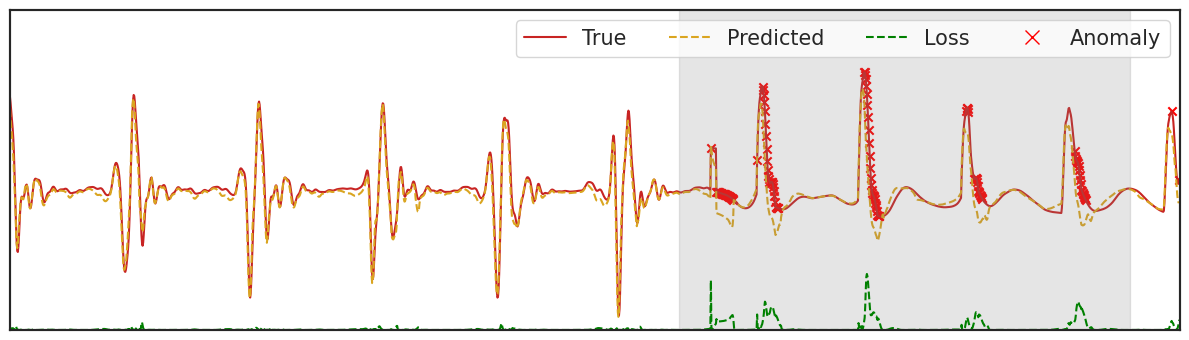

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
import seaborn as sns
sns.set_style("white")
c = 3
t = 32
m = 2100

color = ['#2878B5', '#9AC9DB', '#F8AC8C', '#C82423']


plt.figure(figsize=(12, 3.5))
line1, = plt.plot(full_sequence[t:t + m, c], label='True', c=color[c])
line2, = plt.plot(prediction_res[1:m, c], label='Predicted', linestyle='--', c='#DAA520')

anomalies = np.where(loss[:m, c] > 0.005)[0]  # get indices of anomalies

plt.scatter(anomalies, full_sequence[t + anomalies, c], c='red', marker='x', label='Anomaly')
plt.xlim(0, m)
plt.ylim(0, 1.1)
plt.tick_params(axis='both', which='major', labelsize=12)

# 获取当前轴对象并设置边框加粗
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(1.5)

# 删除坐标轴上的数字和刻度线
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(axis='both', which='both', length=0)

ax2 = plt.twinx()
line3, = ax2.plot(loss[:m, c], label='Loss', linestyle='--', c='g')
ax2.set_ylim(0, 0.2)

# 获取双y轴对象并设置边框加粗
for spine in ax2.spines.values():
    spine.set_linewidth(1.5)

# 删除双y轴上的数字和刻度线
ax2.set_yticklabels([])
ax2.tick_params(axis='y', which='both', length=0)

plt.axvspan(1200, 2010, color='grey', alpha=0.2, label='MI Area')
# plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='grey')

lines = [line1, line2, line3]
lines += [Line2D([0], [0], color='red', marker='x', linestyle='', markersize=10, label='Anomaly')]
labels = [l.get_label() for l in lines]
plt.legend(lines, labels, loc='upper right', ncol=4, fontsize=15)

plt.tight_layout()
plt.savefig("./fig/prediction/prediction_3.png", dpi=300, transparent=True)
plt.show()

In [ ]:
xingeng = pd.read_csv("xingeng_test.csv", index_col=0).values
xingeng = scaler.fit_transform(xingeng)
xingeng = MultiStepTimeSeriesDataset(xingeng, 32, n_steps)
y_true = np.ones(950)
y_pred = np.ones(950)
y_true_3 = np.ones(950)
y_pred_2 = np.ones(950)
y_true_2 = np.ones(950)
y_true_1 = np.ones(950)
y_pred_1 = np.ones(950)
y_pred_3 = np.ones(950)
loss_val = []

with torch.no_grad():
    for i, (x, y) in tqdm(enumerate(xingeng)):
        x, y = x.to(device), y.to(device)
        out = model(x.reshape(-1, 32, 4))
        if i>=950:
            break
        tamp = []
        for j in range(4):
            loss_item = mse(y.reshape(4)[j], out.reshape(4)[j])
            tamp.append(loss_item.cpu())
            if j == 3 and loss_item < thresholds[3]:
                y_pred[i] = 0
            if j == 2 and loss_item < thresholds[2]:
                y_pred_3[i] = 0
            if j == 1 and loss_item < thresholds[1]:
                y_pred_2[i] = 0
            if j == 0 and loss_item < thresholds[0]:
                y_pred_1[i] = 0
        loss_val.append(np.array(tamp))


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def shuffle(y_true_normal, y_pred_normal, y_true_abnormal, y_pred_abnormal):
    y_true = np.concatenate((y_true_normal, y_true_abnormal))
    y_pred = np.concatenate((y_pred_normal, y_pred_abnormal))
    indices = np.arange(y_true.shape[0])
    np.random.shuffle(indices)
    y_true = y_true[indices]
    y_pred = y_pred[indices]
    return y_true, y_pred

fig, ax = plt.subplots(1, 4, figsize=(15,3))

y_true_1, y_pred_1 = shuffle(y_pred_abnormal=y_pred_1, y_true_normal=y_true_normal_1, y_pred_normal=y_pred_normal_1, y_true_abnormal=y_true_1)
fpr, tpr, thresholds = roc_curve(y_true_1, y_pred_1)
roc_auc = auc(fpr, tpr)
lw = 2
ax[1].plot(fpr, tpr, color=color[0],
         lw=lw, label='Ch1 (ROC Area = %0.2f)' % roc_auc)
ax[1].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
ax[1].set_xlim([-0.02, 1.0])
ax[1].grid(True)
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate (FPR)', fontsize=12)
ax[1].set_ylabel('True Positive Rate (TPR)', fontsize=12)
ax[1].legend(loc="lower right", fontsize=12)

y_true_2, y_pred_2 = shuffle(y_pred_abnormal=y_pred_2, y_true_normal=y_true_normal_2, y_pred_normal=y_pred_normal_2, y_true_abnormal=y_true_2)
fpr, tpr, thresholds = roc_curve(y_true_2, y_pred_2)
roc_auc = auc(fpr, tpr)
lw = 2
ax[0].plot(fpr, tpr, color=color[1],
         lw=lw, label='Ch2 (ROC Area = %0.2f)' % roc_auc)
ax[0].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
ax[0].set_xlim([-0.02, 1.0])
ax[0].grid(True)
ax[0].set_ylim([0.0, 1.05])
ax[0].set_xlabel('False Positive Rate (FPR)', fontsize=12)
ax[0].set_ylabel('True Positive Rate (TPR)', fontsize=12)
ax[0].legend(loc="lower right", fontsize=12)


y_true_4, y_pred_4 = shuffle(y_pred_abnormal=y_pred, y_true_normal=y_true_normal, y_pred_normal=y_pred_normal, y_true_abnormal=y_true)
fpr, tpr, thresholds = roc_curve(y_true_4, y_pred_4)
roc_auc = auc(fpr, tpr)
lw = 2
ax[3].plot(fpr, tpr, color=color[3],
         lw=lw, label='Ch4 (ROC Area = %0.2f)' % roc_auc)
ax[3].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
ax[3].set_xlim([-0.02, 1.0])
ax[3].grid(True)
ax[3].set_ylim([0.0, 1.05])
ax[3].set_xlabel('False Positive Rate (FPR)', fontsize=12)
ax[3].set_ylabel('True Positive Rate (TPR)', fontsize=12)
ax[3].legend(loc="lower right", fontsize=12)

y_true_3, y_pred_3 = shuffle(y_pred_abnormal=y_pred_3, y_true_normal=y_true_normal_3, y_pred_normal=y_pred_normal_3, y_true_abnormal=y_true_3)
fpr, tpr, thresholds = roc_curve(y_true_3, y_pred_3)
roc_auc = auc(fpr, tpr)
lw = 2
ax[1].plot(fpr, tpr, color=color[2],
         lw=lw, label='Ch3 (ROC Area = %0.2f)' % roc_auc)
ax[1].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
ax[1].set_xlim([-0.02, 1.0])
ax[1].grid(True)
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate (FPR)', fontsize=12)
ax[1].set_ylabel('True Positive Rate (TPR)', fontsize=12)
ax[1].legend(loc="lower right", fontsize=12)

for spine in ax[1].spines.values():
    spine.set_linewidth(2)
for spine in ax[0].spines.values():
    spine.set_linewidth(2)
for spine in ax[1].spines.values():
    spine.set_linewidth(2)
for spine in ax[3].spines.values():
    spine.set_linewidth(2)
plt.tight_layout()

plt.savefig('roc_new.png', dpi=300)


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
def shuffle(y_true_normal, y_pred_normal, y_true_abnormal, y_pred_abnormal):
    y_true = np.concatenate((y_true_normal, y_true_abnormal))
    y_pred = np.concatenate((y_pred_normal, y_pred_abnormal))
    indices = np.arange(y_true.shape[0])
    np.random.shuffle(indices)
    y_true = y_true[indices]
    y_pred = y_pred[indices]
    return y_true, y_pred

y_true_1, y_pred_1 = shuffle(y_pred_abnormal=y_pred_1, y_true_normal=y_true_normal_1, y_pred_normal=y_pred_normal_1, y_true_abnormal=y_true_1)
fpr, tpr, thresholds = roc_curve(y_true_1, y_pred_1)
roc_auc = auc(fpr, tpr)
lw = 2
plt.plot(fpr, tpr, color=color[0],
         lw=lw, label='Ch1 (ROC Area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.grid(True)
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)

y_true_2, y_pred_2 = shuffle(y_pred_abnormal=y_pred_2, y_true_normal=y_true_normal_2, y_pred_normal=y_pred_normal_2, y_true_abnormal=y_true_2)
fpr, tpr, thresholds = roc_curve(y_true_2, y_pred_2)
roc_auc = auc(fpr, tpr)
lw = 2
plt.plot(fpr, tpr, color=color[1],
         lw=lw, label='Ch2 (ROC Area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.set_xlim([-0.02, 1.0])
# ax[0].grid(True)
# ax[0].set_ylim([0.0, 1.05])
# ax[0].set_xlabel('False Positive Rate (FPR)', fontsize=12)
# ax[0].set_ylabel('True Positive Rate (TPR)', fontsize=12)
# ax[0].legend(loc="lower right", fontsize=12)


y_true_4, y_pred_4 = shuffle(y_pred_abnormal=y_pred, y_true_normal=y_true_normal, y_pred_normal=y_pred_normal, y_true_abnormal=y_true)
fpr, tpr, thresholds = roc_curve(y_true_4, y_pred_4)
roc_auc = auc(fpr, tpr)
lw = 2
plt.plot(fpr, tpr, color=color[3],
         lw=lw, label='Ch4 (ROC Area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.set_xlim([-0.02, 1.0])
# ax[3].grid(True)
# ax[3].set_ylim([0.0, 1.05])
# ax[3].set_xlabel('False Positive Rate (FPR)', fontsize=12)
# ax[3].set_ylabel('True Positive Rate (TPR)', fontsize=12)
# ax[3].legend(loc="lower right", fontsize=12)

y_true_3, y_pred_3 = shuffle(y_pred_abnormal=y_pred_3, y_true_normal=y_true_normal_3, y_pred_normal=y_pred_normal_3, y_true_abnormal=y_true_3)
fpr, tpr, thresholds = roc_curve(y_true_3, y_pred_3)
roc_auc = auc(fpr, tpr)
lw = 2
plt.plot(fpr, tpr, color=color[2],
         lw=lw, label='Ch3 (ROC Area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([-0.02, 1.0])
# ax[1].grid(True)
# ax[1].set_ylim([0.0, 1.05])
# ax[1].set_xlabel('False Positive Rate (FPR)', fontsize=12)
# ax[1].set_ylabel('True Positive Rate (TPR)', fontsize=12)
# ax[1].legend(loc="lower right", fontsize=12)

for spine in ax[1].spines.values():
    spine.set_linewidth(2)
for spine in ax[0].spines.values():
    spine.set_linewidth(2)
for spine in ax[1].spines.values():
    spine.set_linewidth(2)
for spine in ax[3].spines.values():
    spine.set_linewidth(2)
plt.tight_layout()
plt.legend(loc="lower right", fontsize=12)

plt.savefig('roc_new.png', dpi=300)


In [209]:
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score
color = ['#2878B5', '#9AC9DB', '#F8AC8C', '#C82423']

color = ['#2878B5', '#9AC9DB', '#F8AC8C', '#C82423']

# 计算各个通道的指标
def metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)*100
    p = precision_score(y_true, y_pred)*100
    r = recall_score(y_true, y_pred)*100
    f1 = f1_score(y_true, y_pred)*100
    return acc, p, r, f1
ch1_metrics = metrics(y_true_1, y_pred_1)
ch2_metrics = metrics(y_true_2, y_pred_2)
ch3_metrics = metrics(y_true_3, y_pred_3)
ch4_metrics = metrics(y_true_4, y_pred_4)

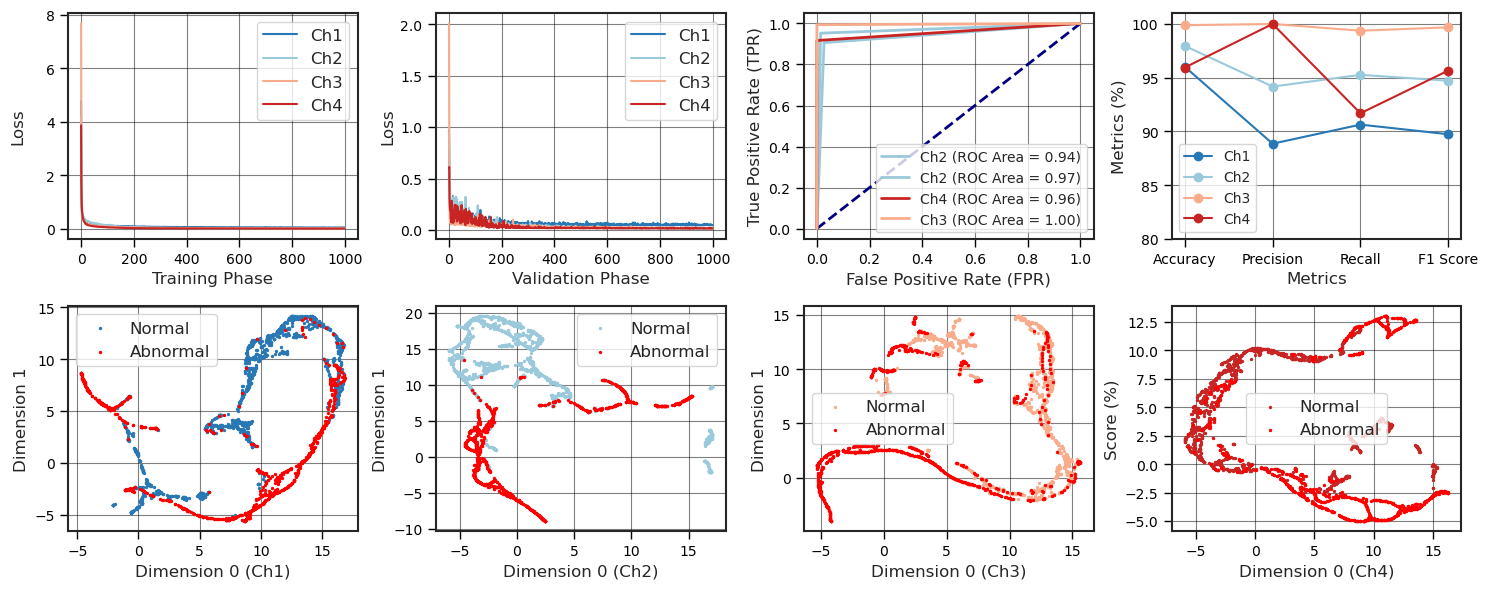

In [271]:

# ch1_metrics = metrics(y_true_1, y_pred_1)
# ch2_metrics = metrics(y_true_2, y_pred_2)
# ch3_metrics = metrics(y_true_3, y_pred_3)
# ch4_metrics = metrics(y_true_4, y_pred_4)

# # 指标标签
# metrics_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# # 各通道的指标值
# channels_metrics = [ch1_metrics, ch2_metrics, ch3_metrics, ch4_metrics]

# fig, ax = plt.subplots(1, 4, figsize=(15, 3))

# # 设置柱状图宽度
# bar_width = 0.4
# bar_positions = np.arange(len(channels_metrics))

color = ['#2878B5', '#9AC9DB', '#F8AC8C', '#C82423']
import seaborn as sns
sns.set_style('white')
fig, ax = plt.subplots(2, 4, figsize=(15, 6))
ax[1,0].scatter(hidden_states_umap_1[:1300, 0], hidden_states_umap_1[:1300, 1], c=color[0], s=2, label='Normal')
ax[1,0].scatter(hidden_states_umap_1[1300:2300, 0], hidden_states_umap_1[1300:2300, 1], c='r', s=2, label='Abnormal')
ax[1,0].set_xlabel("Dimension 0 (Ch1)",fontsize=12)
ax[1,0].set_ylabel("Dimension 1",fontsize=12)
ax[1,0].legend(fontsize=12)
ax[1,0].grid(True)

ax[1,1].scatter(hidden_states_umap_2[:1300, 0], hidden_states_umap_2[:1300, 1], c=color[1], s=2,label='Normal')
# ax[1,1].scatter(hidden_states_umap_2[2300:, 0], hidden_states_umap_2[2300:, 1], c=color[1], s=2, label='abnormal')
ax[1,1].scatter(hidden_states_umap_2[1300:, 0], hidden_states_umap_2[1300:, 1], c='r', s=2, label='Abnormal')
ax[1,1].set_xlabel("Dimension 0 (Ch2)",fontsize=12)
ax[1,1].set_ylabel("Dimension 1",fontsize=12)
ax[1,1].legend(fontsize=12)
ax[1,1].grid(True)
ax[1,2].scatter(hidden_states_umap_3[:1300, 0], hidden_states_umap_3[:1300, 1], c=color[2], s=2,label='Normal')
# ax[1].scatter(hidden_states_umap_3[:100, 0], hidden_states_umap_3[:1300, 1], c=color[2], s=2)
ax[1,2].scatter(hidden_states_umap_3[1300:, 0], hidden_states_umap_3[1300:, 1], c='r', s=2, label='Abnormal')
ax[1,2].set_xlabel("Dimension 0 (Ch3)",fontsize=12)
ax[1,2].set_ylabel("Dimension 1",fontsize=12)
ax[1,2].legend(fontsize=12)
ax[1,2].grid(True)
ax[1,3].scatter(hidden_states_umap_4[:1300, 0], hidden_states_umap_4[:1300, 1], c=color[3], s=2,label='Normal')
ax[1,3].scatter(hidden_states_umap_4[1300:, 0], hidden_states_umap_4[1300:, 1], c='r', s=2, label='Abnormal')
ax[1,3].set_xlabel("Dimension 0 (Ch4)",fontsize=12)
ax[1,3].set_ylabel("Dimension 1", fontsize=12)
ax[1,3].legend(fontsize=12)
ax[1,3].grid(True)


metrics_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# 各通道的指标值
channels_metrics = [ch1_metrics, ch2_metrics, ch3_metrics, ch4_metrics]


# 绘制各通道的指标折线图
for i, (metrics, col) in enumerate(zip(channels_metrics, color)):
    ax[0,3].plot(metrics_labels, metrics, marker='o', color=col, label=f'Ch{i+1}')

# 设置图例
ax[0,3].legend()
ax[0,3].set_ylim(80, 101)
ax[0,3].tick_params(axis='x')
ax[0,3].set_ylabel("Metrics (%)", fontsize=12)
ax[0,3].grid(True)
ax[0,3].set_xlabel('Metrics', fontsize=12)
plt.ylabel('Score (%)', fontsize=12)

y_true_1, y_pred_1 = shuffle(y_pred_abnormal=y_pred_1, y_true_normal=y_true_normal_1, y_pred_normal=y_pred_normal_1, y_true_abnormal=y_true_1)
fpr, tpr, thresholds = roc_curve(y_true_1, y_pred_1)
roc_auc = auc(fpr, tpr)
ax[0,2].plot(fpr, tpr, color=color[1],
         lw=lw, label='Ch2 (ROC Area = %0.2f)' % roc_auc)
ax[0, 2].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
y_true_2, y_pred_2 = shuffle(y_pred_abnormal=y_pred_2, y_true_normal=y_true_normal_2, y_pred_normal=y_pred_normal_2, y_true_abnormal=y_true_2)
fpr, tpr, thresholds = roc_curve(y_true_2, y_pred_2)
roc_auc = auc(fpr, tpr)
ax[0,2].plot(fpr, tpr, color=color[1],
         lw=lw, label='Ch2 (ROC Area = %0.2f)' % roc_auc)
y_true_4, y_pred_4 = shuffle(y_pred_abnormal=y_pred, y_true_normal=y_true_normal, y_pred_normal=y_pred_normal, y_true_abnormal=y_true)
fpr, tpr, thresholds = roc_curve(y_true_4, y_pred_4)
roc_auc = auc(fpr, tpr)
ax[0,2].plot(fpr, tpr, color=color[3],
         lw=lw, label='Ch4 (ROC Area = %0.2f)' % roc_auc)
y_true_3, y_pred_3 = shuffle(y_pred_abnormal=y_pred_3, y_true_normal=y_true_normal_3, y_pred_normal=y_pred_normal_3, y_true_abnormal=y_true_3)
fpr, tpr, thresholds = roc_curve(y_true_3, y_pred_3)
roc_auc = auc(fpr, tpr)
ax[0,2].plot(fpr, tpr, color=color[2],
         lw=lw, label='Ch3 (ROC Area = %0.2f)' % roc_auc)
ax[0,2].legend(loc="lower right", fontsize=10)

ax[0,2].set_xlabel('False Positive Rate (FPR)', fontsize=12)
ax[0,2].set_ylabel('True Positive Rate (TPR)', fontsize=12)

ax[0,2].grid(True)
train_loss = pd.read_csv('train_loss.csv', index_col=0).values
val_loss = pd.read_csv('val_loss.csv', index_col=0).values
ax[0,0].plot(train_loss[:, 0], label='Ch1', c=color[0])
ax[0,0].plot(train_loss[:, 1], label='Ch2', c=color[1])
ax[0,0].plot(train_loss[:, 2], label='Ch3', c=color[2])
ax[0,0].plot(train_loss[:, 3], label='Ch4', c=color[3])
ax[0,0].legend(fontsize=12)
ax[0,0].set_xlabel("Training Phase", fontsize=12)
ax[0,0].set_ylabel("Loss", fontsize=12, labelpad=15)
ax[0,0].grid(True)
ax[0,1].plot(val_loss[:, 0], label='Ch1', c=color[0])
ax[0,1].plot(val_loss[:, 1], label='Ch2', c=color[1])
ax[0,1].plot(val_loss[:, 2], label='Ch3', c=color[2])
ax[0,1].plot(val_loss[:, 3], label='Ch4', c=color[3])
ax[0,1].legend(fontsize=12)
ax[0,1].set_xlabel("Validation Phase", fontsize=12)
ax[0,1].set_ylabel("Loss", fontsize=12)
ax[0,1].grid(True)
for i in range(2):
    for j in range(4):
        for spine in ax[i,j].spines.values():
            spine.set_linewidth(1.5)
        ax[i,j].tick_params(axis='both', which='both', direction='out', length=6, width=1, colors='k', grid_color='k', grid_alpha=0.5)
        ax[i,j].xaxis.set_ticks_position(position='bottom')
        ax[i,j].yaxis.set_ticks_position(position='left')
plt.tight_layout()
plt.savefig('performance.png', dpi=300)
plt.show()



In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import torch.nn.functional as F


def compute_grad_cam(model, inputs, labels):
    mse = nn.MSELoss()
    model.train()  # 确保模型处于训练模式
    transformer_outs = [None] * model.input_dim
    grads = [None] * model.input_dim

    def forward_hook(module, input, output, idx):
        transformer_outs[idx] = output

    def backward_hook(module, grad_in, grad_out, idx):
        grads[idx] = grad_out[0]

    handles = []
    for idx, transformer in enumerate(model.transformers):
        handle_forward = transformer.decoder.register_forward_hook(lambda m, i, o, idx=idx: forward_hook(m, i, o, idx))
        handle_backward = transformer.decoder.register_backward_hook(lambda m, gi, go, idx=idx: backward_hook(m, gi, go, idx))
        handles.append((handle_forward, handle_backward))

    outputs = model(inputs)
    model.zero_grad()

    grad_cam_maps = []
    for idx in range(model.input_dim):
        loss = mse(outputs[:, -1, idx], labels[:, idx])
        loss.backward(retain_graph=True)
        weights = torch.mean(grads[idx], dim=1, keepdim=True)  # 平均权重
        grad_cam_map = torch.sum(weights * transformer_outs[idx], dim=2).cpu().detach().numpy()
        grad_cam_map = np.maximum(grad_cam_map, 0)
        grad_cam_maps.append(grad_cam_map)
        model.zero_grad()
    for handle_forward, handle_backward in handles:
        handle_forward.remove()
        handle_backward.remove()

    model.eval() 
    return grad_cam_maps



data = pd.read_csv("normal_xingeng.csv", index_col=0).values

from tqdm import trange
grad_cam_maps_0 = []
grad_cam_maps_1 = []
grad_cam_maps_2 = []
grad_cam_maps_3 = []
all_predictions = []
for i in trange(0, 2100):
    input_tensor = torch.tensor(data[i:i+32], dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        predicted_sequence = model(input_tensor)
    all_predictions.append(predicted_sequence[0, :, :].detach().cpu().numpy())
    label = torch.tensor(data[i+32], dtype=torch.float32).reshape(1, 4)
    grad_cam_maps = compute_grad_cam(model, input_tensor, label.to(device))
    grad_cam_maps = np.mean(grad_cam_maps, axis=1)
    grad_cam_maps_0.append(grad_cam_maps[0][-1])
    grad_cam_maps_1.append(grad_cam_maps[1][-1])
    grad_cam_maps_2.append(grad_cam_maps[2][-1])
    grad_cam_maps_3.append(grad_cam_maps[3][-1])


In [ ]:
grad_cam_maps_0 = np.array(grad_cam_maps_0)
grad_cam_maps_1 = np.array(grad_cam_maps_1)
grad_cam_maps_2 = np.array(grad_cam_maps_2)

grad_cam_maps_3 = np.array(grad_cam_maps_3)
all_predictions = np.array(all_predictions)
grad_cam_maps[0].shape

/tmp/ipykernel_62633/2102833716.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


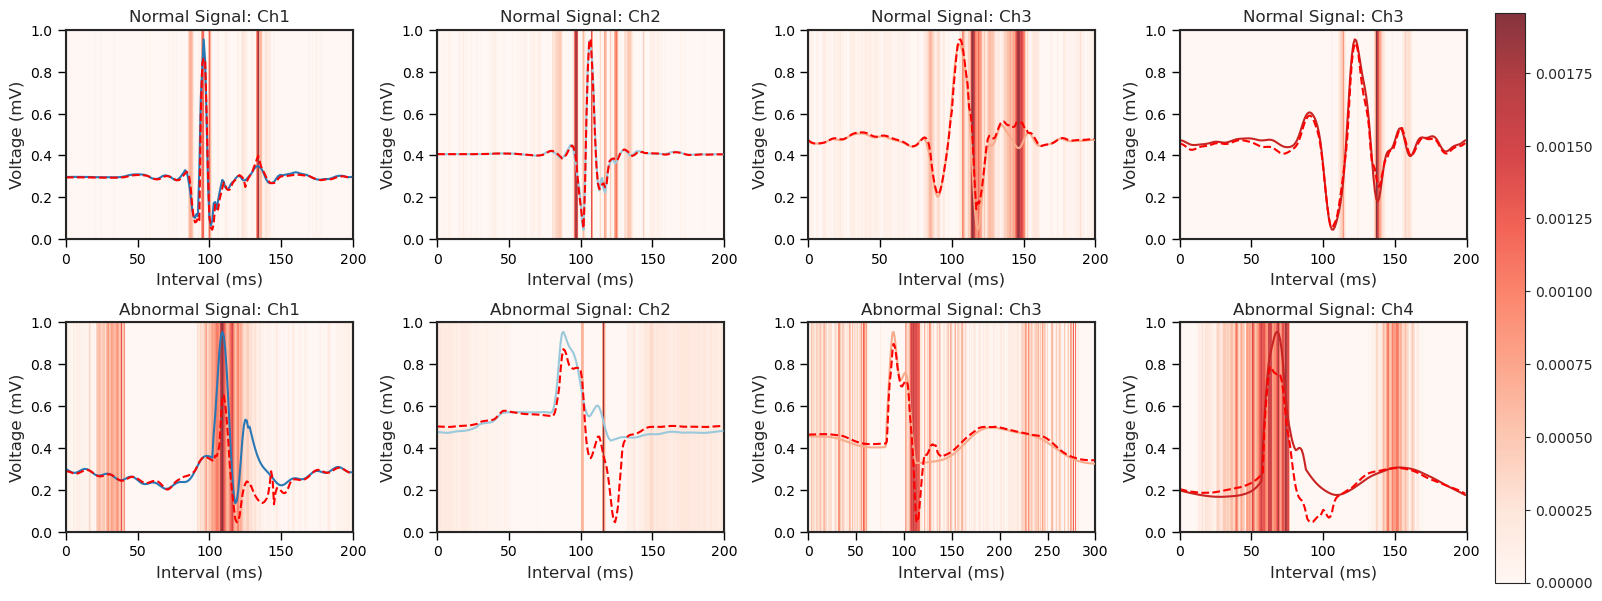

In [294]:
color = ['#2878B5', '#9AC9DB', '#F8AC8C', '#C82423']
import seaborn as sns
sns.set_style('white')
fig, ax = plt.subplots(2, 4, figsize=(15, 6))

im_list = []
c = 32
# 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Grays', 'Greens', 
# 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 
# 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 
# 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 
# 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 
# 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare',
# 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_grey', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 
# 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gist_yerg', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r',
# 'grey', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral',
# 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic',
# 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 
# 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'
im = ax[0, 0].imshow(grad_cam_maps_0[:200].reshape(1, 200), aspect='auto', cmap='Reds', extent=[0, 200 / 1, 0, 1], alpha=0.8)
ax2 = ax[0, 0].twinx()
ax2.plot(data[c:200+c, 0], label='Normal', c=color[0])
ax2.plot(all_predictions[:200,:, 0], label='Prediction', c='r', linestyle='--')
ax[0, 0].set_title("Normal Signal: Ch1", fontsize=12)
ax2.set_yticks([])
ax[0, 0].set_xlabel("Interval (ms)", fontsize=12)
ax[0, 0].set_ylabel("Voltage (mV)", fontsize=12)
im_list.append(im)


im = ax[0, 1].imshow(grad_cam_maps_1[50:250].reshape(1, 200), aspect='auto', cmap='Reds', extent=[0, 200, 0, 1], alpha=0.8)
ax2 = ax[0, 1].twinx()
ax2.plot(data[c+50:250+c, 1], label='Normal', c=color[1])
ax2.plot(all_predictions[50:250,:, 1], label='Prediction', c='r', linestyle='--')
ax[0, 1].set_title("Normal Signal: Ch2", fontsize=12)
ax2.set_yticks([])
ax[0, 1].set_ylabel("Voltage (mV)", fontsize=12)
ax[0, 1].set_xlabel("Interval (ms)", fontsize=12)
im_list.append(im)


im = ax[0, 2].imshow(grad_cam_maps_2[550:750].reshape(1, 200), aspect='auto', cmap='Reds', extent=[0, 200, 0, 1], alpha=0.8)
ax2 = ax[0, 2].twinx()
ax2.plot(data[c+550:750+c, 2], label='Normal', c=color[2])
ax2.plot(all_predictions[550:750,:, 2], label='Prediction', c='r', linestyle='--')
ax[0, 2].set_title("Normal Signal: Ch3", fontsize=12)
ax2.set_yticks([])
ax[0, 2].set_ylabel("Voltage (mV)", fontsize=12)
ax[0, 2].set_xlabel("Interval (ms)", fontsize=12)
im_list.append(im)


im = ax[0, 3].imshow(grad_cam_maps_3[100:300].reshape(1, 200), aspect='auto', cmap='Reds', extent=[0, 200, 0, 1], alpha=0.8)
ax2 = ax[0, 3].twinx()
ax2.plot(data[c+100:c+300, 3], label='Normal', c=color[3])
ax2.plot(all_predictions[100:300,:, 3], label='Prediction', c='r', linestyle='--')
ax[0, 3].set_title("Normal Signal: Ch3", fontsize=12)
ax2.set_yticks([])
ax[0, 3].set_ylabel("Voltage (mV)", fontsize=12)
ax[0, 3].set_xlabel("Interval (ms)", fontsize=12)
im_list.append(im)


im = ax[1, 0].imshow(grad_cam_maps_3[1300:1500].reshape(1, 200), aspect='auto', cmap='Reds', extent=[0, 200, 0, 1], alpha=0.8)
ax2 = ax[1, 0].twinx()
ax2.plot(data[c+1300:1500+c, 0], label='Normal', c=color[0])
ax2.plot(all_predictions[1300:1500,:, 0], label='Prediction', c='r', linestyle='--')
ax[1, 0].set_title("Abnormal Signal: Ch1", fontsize=12)
ax2.set_yticks([])
ax[1, 0].set_ylabel("Voltage (mV)", fontsize=12)
ax[1, 0].set_xlabel("Interval (ms)", fontsize=12)



im = ax[1, 1].imshow(grad_cam_maps_1[1300:1500].reshape(1, 200), aspect='auto', cmap='Reds', extent=[0, 200, 0, 1], alpha=0.8)
ax2 = ax[1, 1].twinx()
ax2.plot(data[c+1300:1500+c, 1], label='Normal', c=color[1])
ax2.plot(all_predictions[1300:1500,:, 1], label='Prediction', c='r', linestyle='--')
ax[1, 1].set_title("Abnormal Signal: Ch2", fontsize=12)
im_list.append(im)

ax2.set_yticks([])
ax[1, 1].set_ylabel("Voltage (mV)", fontsize=12)
ax[1, 1].set_xlabel("Interval (ms)", fontsize=12)



im = ax[1, 2].imshow(grad_cam_maps_2[1720:2020].reshape(1, 300), aspect='auto', cmap='Reds', extent=[0, 300, 0, 1], alpha=0.8)
ax2 = ax[1, 2].twinx()
ax2.plot(data[c+1720:2020+c, 2], label='Normal', c=color[2])
ax2.plot(all_predictions[1720:2020,:, 2], label='Prediction', c='r', linestyle='--')
ax[1, 2].set_title("Abnormal Signal: Ch3", fontsize=12)
ax2.set_yticks([])
ax[1, 2].set_ylabel("Voltage (mV)", fontsize=12)
ax[1, 2].set_xlabel("Interval (ms)", fontsize=12)
im_list.append(im)


im = ax[1, 3].imshow(grad_cam_maps_3[1632:1832].reshape(1, 200), aspect='auto', cmap='Reds', extent=[0, 200, 0, 1], alpha=0.8)
ax2 = ax[1, 3].twinx()
ax2.plot(data[c+1632:1832+c, 3], label='Normal', c=color[3])
ax2.plot(all_predictions[1650:1850 ,:, 3], label='Prediction', c='r',linestyle='--')
ax[1, 3].set_title("Abnormal Signal: Ch4", fontsize=12)
ax2.set_yticks([])
ax[1, 3].set_ylabel("Voltage (mV)", fontsize=12)
ax[1, 3].set_xlabel("Interval (ms)", fontsize=12)
im_list.append(im)

for i in range(2):
    for j in range(4):
        for spine in ax[i, j].spines.values():
            spine.set_linewidth(1.5)
        ax[i, j].tick_params(axis='both', which='both', direction='out', length=6, width=1, colors='k', grid_color='k', grid_alpha=0.5)
        ax[i, j].xaxis.set_ticks_position(position='bottom')
        ax[i, j].yaxis.set_ticks_position(position='left')
cbar_ax = fig.add_axes([1, 0.02, 0.02, 0.95]) 

fig.colorbar(im_list[0], cax=cbar_ax)

plt.tight_layout()
plt.savefig("vist.png", dpi=300, bbox_inches='tight')